## Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## Loading the Data

In [7]:
data = pd.read_csv('D:/BIA Data Science & AI/ML/temperature.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Datetime     7056 non-null   object 
 2   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.5+ KB


In [11]:
data.head()

,Unnamed: 0,Datetime,Hourly_Temp
0,0,04-01-2022 00:00,20.867
1,1,04-01-2022 01:00,21.000
2,2,04-01-2022 02:00,20.867
3,3,04-01-2022 03:00,20.650
4,4,04-01-2022 04:00,20.400


## Data Preprocessing

In [14]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format = '%d-%m-%Y %H:%M')

In [16]:
data.set_index('Datetime', inplace = True)

In [18]:
data.head()

,Unnamed: 0,Hourly_Temp
Datetime,,
2022-01-04 00:00:00,0,20.867
2022-01-04 01:00:00,1,21.000
2022-01-04 02:00:00,2,20.867
2022-01-04 03:00:00,3,20.650
2022-01-04 04:00:00,4,20.400


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7056 entries, 2022-01-04 00:00:00 to 2022-10-24 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 165.4 KB


## Data Visualization

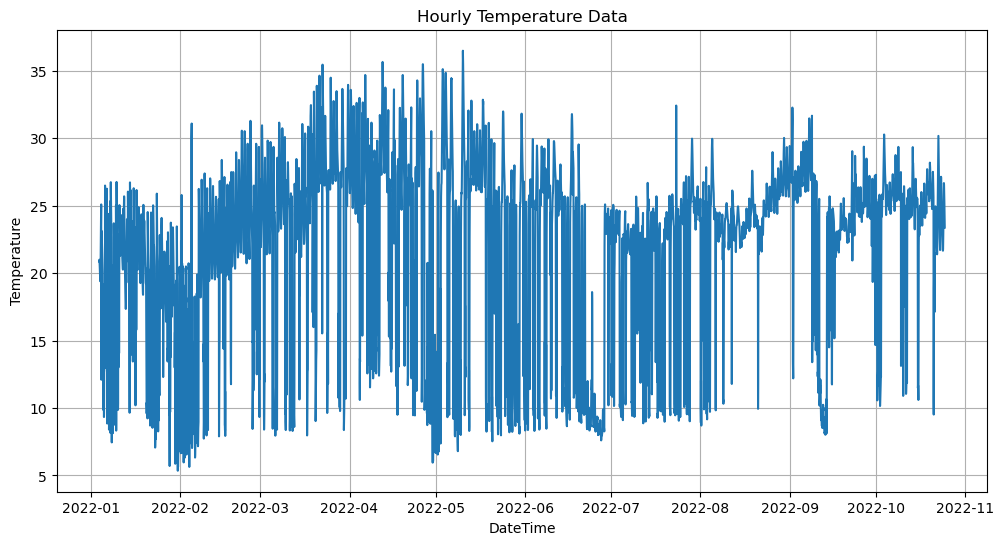

In [23]:
plt.figure(figsize = (12, 6))
plt.plot(data['Hourly_Temp'])
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.title('Hourly Temperature Data')
plt.grid(True)
plt.show()

## Checking Stationarity of Data

In [41]:
def test_stationarity(timeseries):
    # Dickey-Fuller test
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'P-Value', \
                                               '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values: (%s)' %key] = value
        
    return dfoutput

result = test_stationarity(data['Hourly_Temp'])
print("Augmented Dickey-Fuller Test Result is:\n", result)

Augmented Dickey-Fuller Test Result is:
 Test Statistic                -9.395274e+00
P-Value                        6.399293e-16
#Lags Used                     2.500000e+01
Number of Observations Used    7.028000e+03
Critical Values: (1%)         -3.431281e+00
Critical Values: (5%)         -2.861951e+00
Critical Values: (10%)        -2.566989e+00
dtype: float64


## Perform Differencing

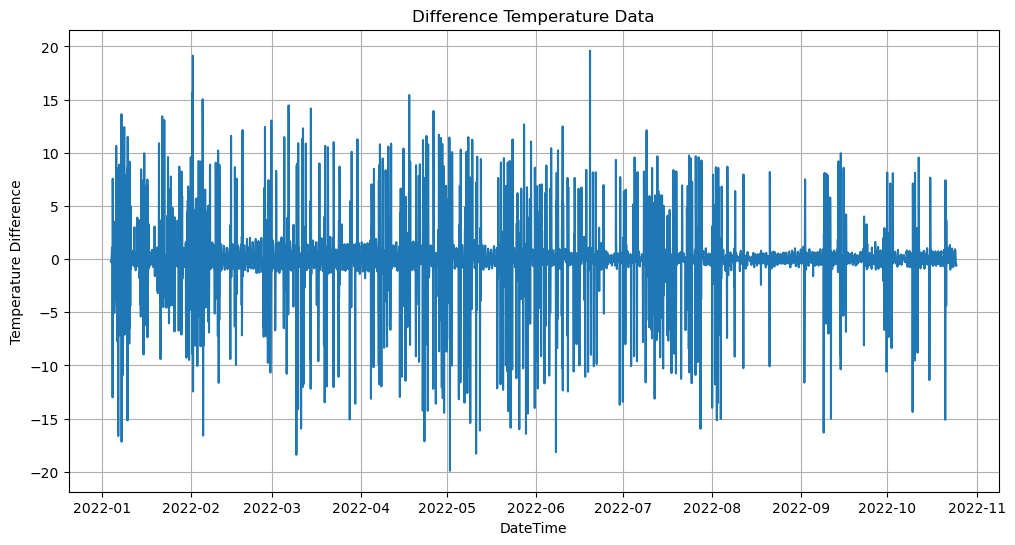

In [44]:
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data.dropna(inplace = True)

# Plot Difference Temp Data
plt.figure(figsize = (12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Difference Temperature Data')
plt.xlabel('DateTime')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()

## Checking the Stationarity on the Temperature Difference Data

In [52]:
result = test_stationarity(data['Temp_Diff'])
print("Augmented Dickery-Fuller Test on Differenced Data is:\n", result)

Augmented Dickery-Fuller Test on Differenced Data is:
 Test Statistic                  -20.536255
P-Value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7017.000000
Critical Values: (1%)            -3.431282
Critical Values: (5%)            -2.861952
Critical Values: (10%)           -2.566989
dtype: float64


## Fit SARIMA Model

In [57]:
model = SARIMAX(data['Hourly_Temp'], order = (1, 1, 1), \
              seasonal_order = (1, 1, 1, 24))
results = model.fit(disp = False)

## Forecasting Future Values

In [145]:
forecast_steps = 24
forecast = results.get_forecast(steps = forecast_steps)

In [147]:
date_range = pd.date_range(start = data.index[-1], periods = forecast_steps + 1, \
                          freq = 'H')

In [149]:
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [151]:
df = pd.DataFrame({'Forecast': forecast_values, \
                   'Lower_CI': forecast_conf_int.iloc[:, 0], \
                   'Upper_CI': forecast_conf_int.iloc[:, 1]}, \
                    index = date_range[1:])

## Plotting the Original Data along with Forecasted Data

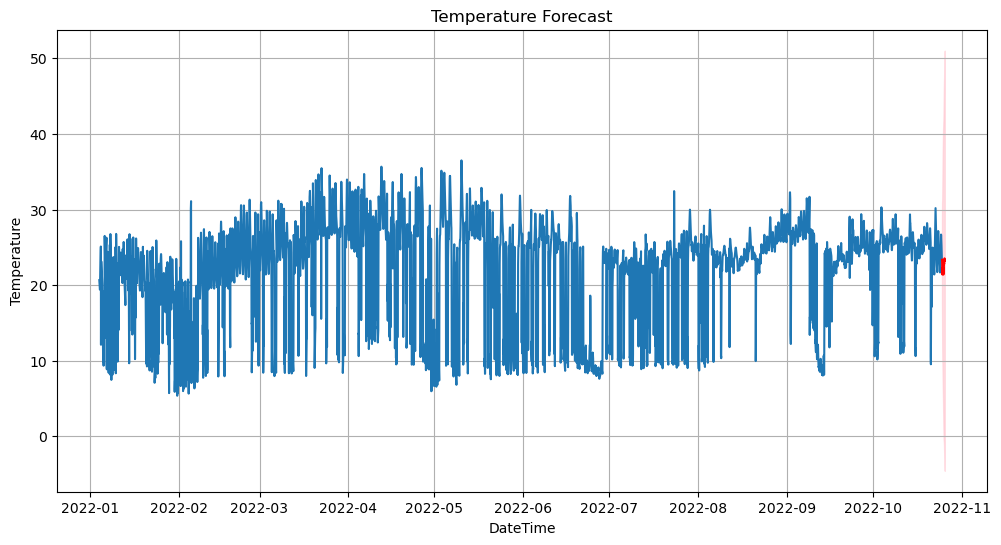

In [154]:
plt.figure(figsize = (12, 6))
plt.plot(data['Hourly_Temp'], label = 'Original Data')
plt.plot(df['Forecast'], label = 'Forecast', color = 'red')
plt.fill_between(df.index, df['Lower_CI'], df['Upper_CI'], \
                color = 'pink', alpha = 0.5, label = '95% Confidence Interval')
plt.title('Temperature Forecast')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()